# Prototyping 1D EFGP 

In [121]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import finufft
import time
import math
from efgp1d import compute_convolution_vector_vectorized, FFTConv1d, BatchFFTConv1d

# Boring GP sampler

In [122]:
import torch
import time
import numpy as np # Keep for potential comparison or other utilities

# --- Parameters ---
n = 300  # Number of points
true_length_scale = 0.1
true_variance = 2.0
true_noise_variance = 0.1
dtype = torch.float64 # Use float64 as in the original example
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Use GPU if available
print(f"Using device: {device}")

# --- Generate Input Points ---
x = torch.linspace(-1, 1, n, dtype=dtype, device=device)

# generate random points from -1 to 1
x = torch.rand(n, dtype=dtype, device=device) * 2 - 3



# --- Define Mean and Covariance Functions (using PyTorch) ---
def mean_func_torch(x):
    """Mean function (returns zero vector)."""
    # Make sure output shape matches input batch shape if any
    return torch.zeros(x.shape[0], dtype=x.dtype, device=x.device)

# CORRECTED RBF Kernel Function
def rbf_kernel_torch(x1, x2, length_scale=1.0, variance=1.0):
    """
    Radial Basis Function (RBF) kernel using PyTorch.
    Calculates variance * exp(-0.5 * ||x1 - x2||^2 / length_scale^2)
    Handles both 1D (n,) and multi-dimensional (n, d) inputs correctly.
    """
    # Ensure inputs are at least 2D for consistent distance calculation
    if x1.ndim == 1:
        x1 = x1.unsqueeze(-1) # Shape becomes (n, 1)
    if x2.ndim == 1:
        x2 = x2.unsqueeze(-1) # Shape becomes (n, 1) or (m, 1)

    # Compute pairwise squared Euclidean distances using broadcasting
    # dist_sq = ||a - b||^2 = ||a||^2 - 2a^T b + ||b||^2
    sum_sq_x1 = torch.sum(x1**2, dim=1, keepdim=True)  # Shape (n, 1)
    sum_sq_x2 = torch.sum(x2**2, dim=1)              # Shape (m,)
    cross_term = torch.matmul(x1, x2.T)               # Shape (n, m)

    # sq_dist shape: (n, 1) + (m,) - 2 * (n, m) -> broadcasting -> (n, m)
    sq_dist = sum_sq_x1 + sum_sq_x2 - 2 * cross_term

    # Ensure squared distances are non-negative (due to potential floating point inaccuracies)
    sq_dist = torch.clamp(sq_dist, min=0.0)

    # Compute the RBF kernel
    cov = variance * torch.exp(-0.5 * sq_dist / length_scale**2)
    return cov

# --- Optimized Sampling Function ---
def sample_gp_fast(x, mean_func, cov_func, num_samples, length_scale, variance, noise_variance):
    """
    Samples efficiently from a Gaussian Process by pre-computing
    the Cholesky decomposition of the noisy covariance matrix.

    Parameters:
    x : torch.Tensor (n) or (n, d)
        Input points.
    mean_func : callable
        Mean function.
    cov_func : callable
        Covariance function (kernel).
    num_samples : int
        Number of samples to draw.
    length_scale : float
        Kernel length scale.
    variance : float
        Kernel variance.
    noise_variance : float
        Variance of the observation noise.

    Returns:
    torch.Tensor (n, num_samples)
        Samples from the GP at the input points x.
    """
    n_points = x.shape[0]
    mean = mean_func(x) # Should be shape (n_points,)

    # 1. Compute Covariance Matrix K
    K = cov_func(x, x, length_scale=length_scale, variance=variance) # (n_points, n_points)

    # 2. Add Noise Variance to Diagonal
    K_noisy = K + noise_variance * torch.eye(n_points, dtype=x.dtype, device=x.device)

    # Add small jitter for numerical stability if noise_variance is very small/zero
    # Consider adding jitter especially if Cholesky fails often
    # jitter_val = 1e-6
    # K_noisy += jitter_val * torch.eye(n_points, dtype=x.dtype, device=x.device)

    # 3. Compute Cholesky Factor L (K_noisy = L L^T)
    # Use torch.linalg.cholesky for better numerical stability handling
    try:
        # Ensure K_noisy is C-contiguous for Cholesky if needed (often automatic)
        # K_noisy = K_noisy.contiguous()
        L = torch.linalg.cholesky(K_noisy) # (n_points, n_points), lower triangular
    except torch.linalg.LinAlgError as e:
        print(f"Cholesky decomposition failed: {e}")
        print("The covariance matrix might not be positive definite.")
        print("Try adding jitter (uncomment the jitter lines) or check kernel parameters.")
        # Fallback with jitter
        jitter = 1e-6 * torch.eye(n_points, dtype=x.dtype, device=x.device)
        try:
            L = torch.linalg.cholesky(K_noisy + jitter)
            print("Cholesky succeeded after adding jitter.")
        except torch.linalg.LinAlgError as e2:
            print(f"Cholesky decomposition failed even with jitter: {e2}")
            raise RuntimeError("Could not compute Cholesky decomposition.") from e2


    # 4. Efficient Sampling
    # Draw standard normal samples Z ~ N(0, I)
    Z = torch.randn(n_points, num_samples, dtype=x.dtype, device=x.device) # (n_points, num_samples)

    # Compute samples: Y = mean + L @ Z
    # Reshape mean to (n_points, 1) for broadcasting
    samples = mean.unsqueeze(1) + L @ Z # (n_points, num_samples)

    return samples

# --- Generate Samples ---
print(f"Generating {1} samples for n={n} points...")
start_time = time.time()

# Sample using the optimized function
# Note: We pass the parameters directly now
y = sample_gp_fast(
    x,
    mean_func_torch,
    rbf_kernel_torch,
    num_samples=1,
    length_scale=true_length_scale,
    variance=true_variance,
    noise_variance=true_noise_variance
).flatten()

end_time = time.time()
print(f"Generated of size {y.shape[0]}.")
print(f"Time taken: {end_time - start_time:.4f} seconds")


Using device: cpu
Generating 1 samples for n=300 points...
Generated of size 300.
Time taken: 0.0020 seconds


In [123]:
# save (x,y) to a torch file
# torch.save((x,y), f'gp_samples_{n}_{true_length_scale}_{true_variance}_{true_noise_variance}.pt')


In [124]:
# load (x,y) from a torch file
# x, y = torch.load(f'gp_samples_{n}_{true_length_scale}_{true_variance}_{true_noise_variance}.pt')

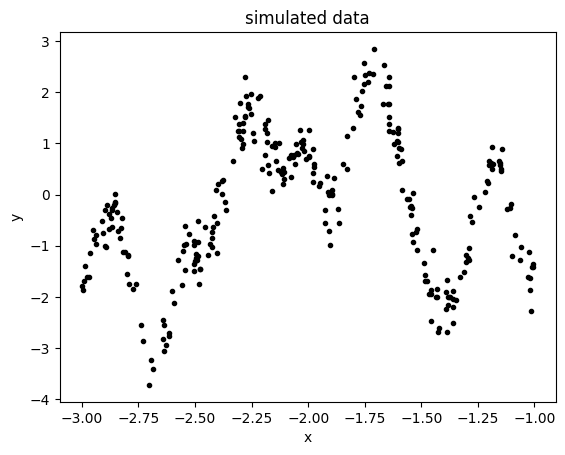

In [125]:
# generate data 
freq = 0.5    
# 1. Generate synthetic data (or use your data)
# x = torch.linspace(0, 5, n, dtype=torch.float64)
# y = torch.sin(x) + 0.1 * torch.randn(n, dtype=torch.float64) + torch.exp(-x) + 1/10000*torch.exp(2*x) + torch.exp(-4*x) -3*torch.exp(-x**4/2) 
# add a step function to the data
# y[50:100] += 2

# plot data
plt.plot(x, y, 'k.')
plt.xlabel('x')
plt.ylabel('y')
plt.title('simulated data')
plt.show()



In [126]:
from utils.kernels import get_xis
from kernels.squared_exponential import SquaredExponential

kernel = SquaredExponential(dimension=1, lengthscale=torch.tensor([0.23]), variance=torch.tensor(1.0))
init_kernel = kernel
# kernel = SquaredExponential(dimension=1, lengthscale=torch.tensor([0.5*1e-2]), variance=torch.tensor(1.0))



In [127]:
# Determine problem geometry
L = x.max() - x.min()
N = x.shape[0]
EPSILON = 1e-4
xis, h, mtot = get_xis(kernel_obj=kernel, eps=EPSILON, L=L, use_integral=False, l2scaled=False)
print(xis.shape)


torch.Size([23])


In [128]:
print("Mtot: ", mtot)
print("h: ", h)
print("xis: ", xis)

Mtot:  23
h:  tensor(0.3220, dtype=torch.float64)
xis:  tensor([-3.5422, -3.2202, -2.8982, -2.5762, -2.2541, -1.9321, -1.6101, -1.2881,
        -0.9661, -0.6440, -0.3220,  0.0000,  0.3220,  0.6440,  0.9661,  1.2881,
         1.6101,  1.9321,  2.2541,  2.5762,  2.8982,  3.2202,  3.5422],
       dtype=torch.float64)


In [129]:
ws = torch.sqrt(kernel.spectral_density(xis).to(dtype=torch.complex128) * h)


In [130]:
ws = torch.sqrt(kernel.spectral_density(xis).to(dtype=torch.complex128) * h)
D = torch.diag(ws).to(dtype=torch.complex128)

# manually compute F for testing 

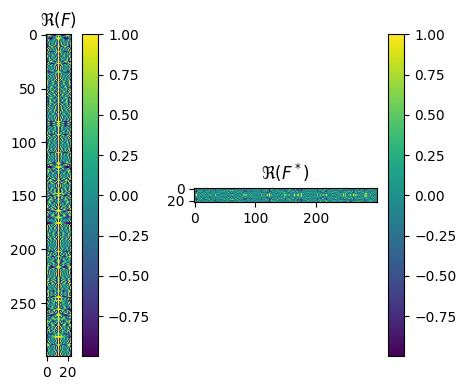

In [131]:
# Form design matrix F
# We do so manually here for clarity (no FFT / NUFFT) x @ j.t()  
F = torch.exp(1j * 2 * torch.pi * torch.outer(x, xis)) 
# F = torch.exp(1j * 2 * torch.pi * (x@xis.t()).to(dtype=torch.complex128))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))

im1 = ax1.imshow(F.real)
plt.colorbar(im1, ax=ax1)
ax1.set_title(r'$\Re(F)$')

im2 = ax2.imshow(F.conj().T.real)
plt.colorbar(im2, ax=ax2)
ax2.set_title(r'$\Re(F^*)$')

plt.tight_layout()
plt.show()

# ws_diag = torch.diag(ws).to(dtype=Phi.dtype) # complex dtype
# A = ws_diag @ (Phi.T @ Phi) @ ws_diag


In [132]:
# create a matrix of distances between x's
dist_matrix = torch.cdist(x.unsqueeze(-1), x.unsqueeze(-1))
# dist_matrix = torch.cdist(x, x)
kernel_matrix = kernel.kernel(dist_matrix)

In [133]:
ws = ws.to(dtype=torch.complex128)
F = F.to(dtype=torch.complex128)
A = D @ (torch.conj(F).T @ F) @ D
kernel_approx =  ((F @ torch.diag(ws)) @ (torch.diag(ws) @ torch.conj(F).T))



# check here $F\alpha$, $F^* \beta$ all close with that calculated w NUFFT 

$$(F \beta)_i  = \sum_{k=1}^M \exp(2\pi i h \langle j_k, x_ i\rangle)\beta_k$$
is a discrete fourier transform, but $\langle j_k, x_i\rangle$ are not uniformly spaced 


$$F\beta = \mathcal{F}(\beta) \in \mathbb C ^N,$$
with spacing given by 
$2\pi h (x)$

In [134]:
eps = EPSILON
# sigmasq = 0.1
# Ensure x and y are float64 and flattened.
x = x.to(dtype=torch.float64).flatten()   # shape: (N,)
y = y.to(dtype=torch.float64).flatten()     # shape: (N,)
# TODO move this outside of the function
x0, x1 = torch.min(x), torch.max(x)
#via NUFFT 
# xcen = (x1+x0)/2
xcen = 0
tphx = 2*math.pi*h*(x - xcen)
nuffttol = 1e-15 # can make this really small bc nufft is fast
isign = -1
fadjbeta = lambda beta: torch.tensor(finufft.nufft1d1(x=tphx.numpy(), c=beta.to(torch.complex128).numpy(),isign= isign, eps= nuffttol, n_modes=mtot)) #O(N+ MlogM)?
    ##NUFFT version
fbeta = lambda beta: torch.tensor(
finufft.nufft1d2(
    x=tphx.numpy(),
    f=beta.to(torch.complex128).numpy(),
    isign=1,
    eps=nuffttol,)
)


In [135]:
fadj_y = F.conj().T@y.to(dtype=torch.complex128)
fadj_y_nufft = fadjbeta(y)
assert torch.allclose(fadj_y, fadj_y_nufft, rtol=1e-4) ,"F Adjoint disagrees"

f_ws = F @ ws 
f_ws_nufft = fbeta(ws)
assert torch.allclose(f_ws, f_ws_nufft, atol=1e-5), "F disagrees" 


Text(0.5, 0.98, 'Approximating kernel matrix with equispaced features, N = 300, M = 23')

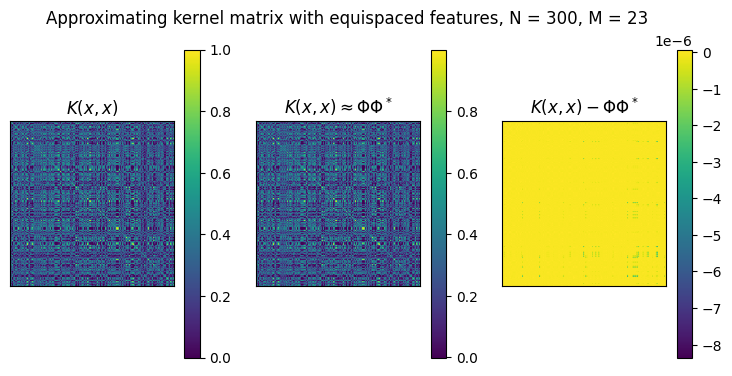

In [136]:
# subplot kernel matrix, kernel approx, and difference side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 4))

im1 = ax1.imshow(kernel_matrix)
plt.colorbar(im1, ax=ax1)
ax1.set_title(r'$K(x, x)$')
# no axis labels
ax1.set_xticks([])
ax1.set_yticks([])

im2 = ax2.imshow(kernel_approx.real)
plt.colorbar(im2, ax=ax2)
ax2.set_title(r'$K(x, x) \approx \Phi \Phi^*$')
ax2.set_xticks([])
ax2.set_yticks([])

diff = kernel_matrix - kernel_approx.real
im3 = ax3.imshow(diff)
plt.colorbar(im3, ax=ax3)
ax3.set_title(r'$K(x, x) - \Phi \Phi^*$')
ax3.set_xticks([])
ax3.set_yticks([])

plt.suptitle(f'Approximating kernel matrix with equispaced features, N = {N}, M = {mtot}')



In [137]:
from efgp_1d_dense import efgp1d_dense
from efgp1d import efgp1d

In [138]:
# make a subset of the data for interpolation and extrapolation
# worked well for N = 200
# x_input = torch.cat([x[:30], x[60:70], x[70:90]])
# y_input = torch.cat([y[:30], y[60:70], y[70:90]])
# for N = 2000
x_input = torch.cat([x[:100], x[300:500], x[650:750]])
y_input = torch.cat([y[:100], y[300:500], y[650:750]])


In [139]:
y_input.shape

torch.Size([100])

In [140]:
# the outputs you get here, for example F, are for the subset of points x_input, not the full x
beta, xis, ytrg, A, F, ws, timing_results = efgp1d_dense(x_input, y_input, sigmasq=torch.tensor(0.1), kernel=kernel, eps=EPSILON, x_new=x, opts={'get_var': True, 'method': 'cholesky', 'get_log_marginal_likelihood': True})

In [141]:
# # plot the beta
# # plt.plot(x, train_posterior['mean'], 'r-', label='posterior mean')
# plt.plot(x, ytrg['mean'], 'r-', label='posterior mean')
# # shaded region for +- 2 std
# plt.fill_between(x, ytrg['mean'] - 2 * torch.sqrt(ytrg['var']), ytrg['mean'] + 2 * torch.sqrt(ytrg['var']), color='r', alpha=0.2)
# plt.plot(x_input, y_input, 'k.', label='data')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('posterior mean and variance')
# plt.legend()
# plt.show()

In [142]:
# the outputs you get here, for example F, are for the subset of points x_input, not the full x
beta_cg, xis_cg, ytrg_cg, A_cg, F_cg, ws_cg, timing_results_cg = efgp1d_dense(x_input, y_input, sigmasq=torch.tensor(0.1), kernel=kernel, eps=EPSILON, x_new=x, opts={'get_var': True, 'method': 'cg', 'get_log_marginal_likelihood': True})


In [143]:
# plt.plot(x, ytrg_cg['mean'], 'b--', label='posterior mean (CG)')
# plt.plot(x, ytrg['mean'], 'r-', label='posterior mean (Cholesky)')
# # plt.fill_between(x, ytrg_cg['mean'] - 2 * torch.sqrt(ytrg_cg['var']), ytrg_cg['mean'] + 2 * torch.sqrt(ytrg_cg['var']), color='b', alpha=0.2)
# plt.plot(x_input, y_input, 'k.', label='data')
# plt.legend()
# plt.show()


In [144]:
# assert torch.allclose(ytrg_cg['mean'], ytrg['mean'], atol=1e-8), "ytrg_cg['mean'] and ytrg['mean'] are not the same"

# CG FFT implementation

# hyper opt cole adds

In [145]:
import time
from cg import ConjugateGradients, BatchConjugateGradients

$$\frac{\partial \mathcal L}{\partial \theta} = \frac{1}{2M} \sum_{k=1}^M z_k^T((K + \sigma^2I)^{-1} \frac{\partial (K + \sigma^2 I)}{\partial \theta}) z_k - \frac{1}{2}y^T (K +\sigma^2 I)^{-1}\frac{\partial (K + \sigma^2 I)}{\partial \theta} (K+\sigma^2I)^{-1}y =I - II $$

In [146]:
xis, h, mtot = get_xis(kernel, 1e-4, L)
print(xis.shape)

torch.Size([23])


# here is the main gradient approx, not batched 

# batched version

# old batched without nufft

In [147]:
sigmasq = torch.tensor(0.1, dtype=torch.float64)  # noise variance


# with nufft

In [148]:
def efgp1d_gradient_batched(x, y, sigmasq, kernel,eps,trace_samples):
    n_hypers = 3  # number of hyperparameters

    # Ensure x and y are float64 and flattened.
    x = x.to(dtype=torch.float64).flatten()   # shape: (N,)
    y = y.to(dtype=torch.float64).flatten()     # shape: (N,)
    # TODO move this outside of the function
    x0, x1 = torch.min(x), torch.max(x)
    L = x1 - x0
    N = x.shape[0]

    # Get Fourier frequencies and quadrature weights.
    xis, h, mtot = get_xis(kernel, eps, L)  # e.g. len(xis)==M, where M=97 for example.

    # Compute weights: ws = sqrt(S(xis) * h)
    ws = torch.sqrt(kernel.spectral_density(xis) * h)  # shape: (M,)
    # We represent D as a diagonal using ws.
    # Convert to complex type.
    ws = ws.to(dtype=torch.complex128)
    v, j_indices = compute_convolution_vector_vectorized(m=int((mtot - 1) / 2), x=x, h=h)
    Afun = lambda beta: ws * BatchFFTConv1d(v, ws * beta)() + sigmasq * beta #O(N + MlogM)?



    #via NUFFT 
    # xcen = (x1+x0)/2
    xcen = 0
    tphx = 2*math.pi*h*(x - xcen)
    # tphxtrgs = 2*math.pi*h*(x - xcen)


    nuffttol = 1e-15
    isign = -1
    fadjbeta = lambda beta: torch.tensor(finufft.nufft1d1(x=tphx.numpy(), c=beta.to(torch.complex128).numpy(),isign= isign, eps= nuffttol, n_modes=mtot)) #O(N+ MlogM)?
        ##NUFFT version
    fbeta = lambda beta: torch.tensor(
    finufft.nufft1d2(
        x=tphx.numpy(),
        f=beta.to(torch.complex128).numpy(),
        isign=1,
        eps=nuffttol,
        # n_modes=mtot
    )
)
    rhs = fadjbeta(y)
    rhs = ws * rhs       


    cg_object = ConjugateGradients(
        A_apply_function=Afun,
        b=rhs,
        x0=torch.zeros_like(rhs),
        early_stopping=False
        # early_stopping=opts.get('early_stopping', False)
    )
    beta = cg_object.solve()  # beta: (M,)
    alpha = 1/sigmasq * (y - fbeta( ws * beta))  # alpha: (N,)

    # -------------------
    Dprime = h * kernel.spectral_grad(xis)  # shape: (M, n_params)
    # This yields the derivative of the diagonal of D^2, since D^2 = diag(S(xis)*h).
    term2 = torch.zeros(n_hypers, dtype=torch.complex128)
    for i in range(3-1):
        ## alpha^* F D' F^* alpha
        fadjalpha = fadjbeta(alpha)
        term2[i] = fadjalpha.conj()@ (Dprime[:,i]*fadjalpha)
    # term2[i] = torch.matmul(alpha.conj().unsqueeze(0),
    #                         torch.matmul(khat_prime[:, :, i], alpha.unsqueeze(1))).squeeze()
    term2[-1] = alpha.conj() @ alpha  # noise term
    # -------------------
    # Compute term 1 (trace term) via Monte Carlo.
    # trace_samples = 10
    # try with rademachers instead..

    ##############################################
    # Monte Carlo Trace Term (term1) using Batch CG solver
    ##############################################
    # Create trace_samples Rademacher vectors. (Each entry is +1 or -1.)
    Z = torch.randint(0, 2, (trace_samples, N), dtype=torch.float64, device=x.device) * 2 - 1  # shape: (trace_samples, N)
    Z = Z.to(dtype=torch.complex128)  # cast to complex for consistency

    # Define a batched operator based on FFTConv1d for use in the CG solver.
    def Afun_batch(beta):
        """
        Batched operator acting on beta of shape (B, M).
        Returns: ws * FFTConv1d(v, ws * beta)() + sigmasq * beta, shape (B, M).
        """
        # Multiply beta by ws elementwise (equivalent to a diagonal D multiplication)
        D_beta = ws * beta
        # FFTConv1d expects the second argument to have shape (B, L); ensure beta is batched.
        conv_result = BatchFFTConv1d(v, D_beta)()  # Output shape: (B, M) if beta is (B, M)
        return ws * conv_result + sigmasq * beta

    term1 = torch.zeros(n_hypers, dtype=torch.complex128)

    # will have to change for different kernels.. 
    for i in range(n_hypers):
        if i<n_hypers-1:
            temp_rhs = (fbeta((fadjbeta(Z) * Dprime[:,i])))
        else:
            temp_rhs = Z
        b_batch = (fadjbeta(temp_rhs) * ws)
        cg_solver = BatchConjugateGradients(
            A_apply_function=Afun_batch,
            b=b_batch,
            x0=torch.zeros_like(b_batch),
            tol=1e-6,
            early_stopping=False
        )
        beta_batch = cg_solver.solve()  # (trace_samples, M)
        alpha_batch = 1/sigmasq * (temp_rhs - (fbeta(beta_batch*ws)))
        dots = torch.sum(Z * alpha_batch, dim=1) 
        term1[i] = torch.mean(dots)




    ##############################################
    # Final Hyperparameter Gradients
    ##############################################
    grad = 0.5 * (term1 - term2)
    grad = grad.real  # if only the real parts are desired
    
    # print("Gradient for hyperparameters:", grad)

    return grad
grad = efgp1d_gradient_batched(x, y, sigmasq, kernel,EPSILON,trace_samples=10)
for i in range(grad.shape[0]):
    print(f"Hyperparameter {i}: gradient approx = {grad[i].real.item():.6f}")


Hyperparameter 0: gradient approx = 2043.940796
Hyperparameter 1: gradient approx = -70.667736
Hyperparameter 2: gradient approx = -1708.050928


# direct inversion using the fourier approximation 
- very similar to auto grad

In [149]:
import torch
import math

def compute_gradients_truncated(x, y, sigmasq, kernel, EPSILON):
    # sigmasq = torch.tensor(0.1, dtype=torch.float64)  # noise variance
    # kernel = SquaredExponential(dimension=1, lengthscale=0.1, variance=1.0)

    # Flatten data to 1D.
    x = x.to(dtype=torch.float64).flatten()   # shape: (N,)
    y = y.to(dtype=torch.float64).flatten()     # shape: (N,)
    x_new = torch.linspace(0, 5, 1000, dtype=torch.float64)

    # Problem geometry.
    x0 = torch.min(x)
    x1 = torch.max(x)
    L_val = x1 - x0
    N = x.shape[0]
    eps = EPSILON
    # eps = 1e-2

    # Get Fourier frequencies and quadrature weights.
    xis, h, mtot = get_xis(kernel, eps, L_val)  # Expect len(xis)=M
    M = len(xis)

    # Compute spectral density and weights.
    # ws = sqrt(S(xis)*h) so that D^2 = diag(S(xis)*h)
    ws = torch.sqrt(kernel.spectral_density(xis) * h)  # shape: (M,)
    D = torch.diag(ws).to(dtype=torch.complex128)         # D: (M, M)

    # Form design features F (N x M): F[n,m] = exp(2pi i * xis[m] * x[n])
    F = torch.exp(1j * 2 * math.pi * torch.outer(x, xis)).to(dtype=torch.complex128)

    # Compute approximate kernel: K = F * D^2 * F^*.
    D2 = D @ D  # This is just diag(ws^2)
    K = F @ D2 @ F.conj().transpose(-2, -1)  # shape: (N, N)
    C = K + sigmasq * torch.eye(N, dtype=torch.complex128)  # add noise term

    # Directly invert C and compute alpha.
    C_inv = torch.linalg.inv(C)
    alpha = C_inv @ y.to(dtype=torch.complex128)  # shape: (N,)

    # Compute derivative of the kernel with respect to the kernel hyperparameters.
    # Let spectral_grad = kernel.spectral_grad(xis), shape: (M, n_params)
    spectral_grad = kernel.spectral_grad(xis)  # shape: (M, n_params)
    # Then dK/dtheta for each kernel hyperparameter i is approximated as:
    # dK/dtheta_i = F * diag( h * spectral_grad(:, i) ) * F^*
    dK_dtheta_list = []
    n_params = spectral_grad.shape[1]
    for i in range(n_params):
        dK_i = F @ torch.diag((h * spectral_grad[:, i]).to(dtype=torch.complex128)) @ F.conj().transpose(-2, -1)
        dK_dtheta_list.append(dK_i)
    # The derivative with respect to the noise parameter is simply the identity.
    dK_dtheta_list.append(torch.eye(N, dtype=torch.complex128))
    n_total = n_params + 1

    # Compute gradient for each hyperparameter using:
    # grad = 0.5 * [trace(C_inv * dK/dtheta) - alpha^H * (dK/dtheta) * alpha]
    grad = torch.zeros(n_total, dtype=torch.complex128)
    for i in range(n_total):
        if i < n_params:
            term1 = torch.trace(C_inv @ dK_dtheta_list[i])
            term2 = (alpha.conj().unsqueeze(0) @ (dK_dtheta_list[i] @ alpha.unsqueeze(1))).squeeze()
        else:  # noise derivative: dC/d(sigmasq) = I
            term1 = torch.trace(C_inv)
            term2 = (alpha.conj().unsqueeze(0) @ alpha.unsqueeze(1)).squeeze()
        grad[i] = 0.5 * (term1 - term2)
        # print('term1:' ,term1.real)
        # print('term2:', term2.real) 

    # Print the gradients (real parts)
    # print("(Truncated) Direct inversion gradient:")
    # print(f"  dNLL/d(lengthscale) = {grad[0].real.item():.6f}")
    # if n_params > 1:
    #     print(f"  dNLL/d(variance)    = {grad[1].real.item():.6f}")
    # print(f"  dNLL/d(noise)       = {grad[-1].real.item():.6f}")
    true_grad = grad.clone()
    # print("term 1: ", term1.real, "term 2: ", term2.real)
    return true_grad.real
# true_grad = compute_gradients_truncated(x, y, sigmasq, kernel, EPSILON)

# auto diff, full kernel, no approximations

In [150]:
# 3. Define the squared-exponential kernel.
def squared_exponential_kernel(x1, x2, lengthscale, variance):
    # Ensure inputs are 2D
    if x1.dim() == 1:
        x1 = x1.unsqueeze(1)
    if x2.dim() == 1:
        x2 = x2.unsqueeze(1)
    # Compute pairwise squared Euclidean distances.
    diff = x1.unsqueeze(1) - x2.unsqueeze(0)   # shape: (n1, n2, d)
    dist_sq = (diff ** 2).sum(dim=2)             # shape: (n1, n2)
    K = variance * torch.exp(-0.5 * dist_sq / (lengthscale ** 2))
    return K

# -------------------------
# 4. Define the negative log marginal likelihood (NLL)
def negative_log_marginal_likelihood(x, y, lengthscale, variance, noise):
    if x.dim() == 1:
        x = x.unsqueeze(1)
    if y.dim() == 1:
        y = y.unsqueeze(1)
    n = x.shape[0]
    # Compute kernel matrix K(X,X) and add noise on the diagonal.
    K = squared_exponential_kernel(x, x, lengthscale, variance) + noise * torch.eye(n, dtype=torch.float64)
    # Compute Cholesky factorization of K.
    L = torch.linalg.cholesky(K)
    # Solve for alpha = K^{-1} y using the Cholesky factors.
    alpha = torch.cholesky_solve(y, L)
    # Compute the log determinant of K via its Cholesky factor.
    logdetK = 2 * torch.sum(torch.log(torch.diag(L)))
    # NLL = 0.5 * y^T K^{-1} y + 0.5 * log|K| + 0.5*n*log(2π)
    nll = 0.5 * torch.matmul(y.T, alpha) + 0.5 * logdetK + 0.5 * n * math.log(2 * math.pi)
    return nll.squeeze()  # return a scalar
def compute_gradients_vanilla(x, y, sigmasq, kernel):
    if x.ndim == 1:
        x = x.unsqueeze(-1)
    if y.ndim == 1:
        y = y.unsqueeze(-1)


    # -------------------------
    # 2. Define hyperparameters as torch tensors with gradients.
    lengthscale = torch.tensor(kernel.lengthscale, dtype=torch.float64, requires_grad=True)
    variance    = torch.tensor(kernel.variance, dtype=torch.float64, requires_grad=True)
    noise       = sigmasq.clone().detach().requires_grad_(True)

    # -------------------------


    # -------------------------
    # 5. Compute the NLL and its gradients.
    nll = negative_log_marginal_likelihood(x, y, lengthscale, variance, noise)
    # print("Negative log marginal likelihood:", nll.item())

    nll.backward()

    # print("\n (VANILLA) Gradients of the negative log marginal likelihood:")
    # print("  dNLL/d(lengthscale) =", lengthscale.grad.item())
    # print("  dNLL/d(variance)    =", variance.grad.item())
    # print("  dNLL/d(noise)       =", noise.grad.item())
    grad = torch.tensor([lengthscale.grad.item(), variance.grad.item(), noise.grad.item()])

    return grad.to(dtype=torch.float64)
grad = compute_gradients_vanilla(x, y, sigmasq, kernel)
print(grad)


tensor([ 2062.5598,   -71.2058, -1702.5979], dtype=torch.float64)


# check that the truncated and vanilla gradients are the same

In [151]:
kernel = init_kernel.model_copy()

grad_trunc = compute_gradients_truncated(x, y, sigmasq, kernel, 1e-20)
grad_vanilla = compute_gradients_vanilla(x, y, sigmasq, kernel)
torch.allclose(grad_trunc,grad_vanilla)


True

In [152]:
lr = 0.005

In [153]:
import warnings
warnings.filterwarnings("ignore", message=".*disabling cuda.*")


In [154]:
grad

tensor([ 2062.5598,   -71.2058, -1702.5979], dtype=torch.float64)

In [155]:
# perform boring SGD using efgp1d_gradient and track hyperparameters
epsilon_values = [1e-4]
# trace_samples_values = [1,10, 50]
trace_samples_values  = [5,10,50]
# precomp = precompute_efgp1d_setup(x, kernel, eps=EPSILON)
min_lengthscale = 0.5*1e-2
import time
results = []
max_iters = 50
for epsilon in epsilon_values:
    for trace_samples in trace_samples_values:
        # time the training
        start_time = time.time()
        kernel = init_kernel.model_copy()
        sigmasq = torch.tensor(0.1, dtype=torch.float64)  # noise variance
        log_marginals = []
        tracked_lengthscales = []
        tracked_variances = []
        tracked_noises = []

        for iter in range(max_iters):  # Perform 20 iterations of SGD
            # Track hyperparameters
            tracked_lengthscales.append(kernel.lengthscale)
            tracked_variances.append(kernel.variance)
            tracked_noises.append(sigmasq)
            # grad = efgp1d_gradient(x, y, sigmasq, kernel, epsilon, trace_samples=trace_samples)
            grad = efgp1d_gradient_batched(x, y, sigmasq, kernel, epsilon, trace_samples=trace_samples)
            # grad = efgp1d_gradient_batched(x, y, sigmasq, kernel, EPSILON, trace_samples, precomp)
            # just clamping this for now
            kernel.lengthscale = max((torch.exp(np.log(kernel.lengthscale) - lr *kernel.lengthscale* grad[0])).item(),min_lengthscale)
            # clamp lengthscale to be greater than some value
            test_variance = max((torch.exp(np.log(kernel.variance) - lr *kernel.variance* grad[1])).item(),1e-5)
            kernel.variance = max((torch.exp(np.log(kernel.variance) - lr *kernel.variance* grad[1])).item(),1e-5)
            lognoise = torch.log(sigmasq) - lr * sigmasq * grad[-1]
            sigmasq = max((torch.exp(lognoise)), 1e-5)
            # print(f"Iteration {iter}: lengthscale = {kernel.lengthscale}, variance = {kernel.variance}, noise = {sigmasq}")
            if iter % 10 == 0:
                print(iter)
            # sigmasq = sigmasq - 0.0001 * grad[2]



            # beta, xis, ytrg = efgp1d(x_input, y_input, sigmasq=sigmasq, kernel=kernel, eps=epsilon, x_new=x, opts={'get_var': True, 'method': 'cholesky', 'get_log_marginal_likelihood': True})
            # log_marginals.append(kernel.log_marginal(x, y, sigmasq))
            # if iter % 10 == 0:
            #     print(f"Epsilon {epsilon}, Trace samples {trace_samples}, Iteration {iter}: log marginal = {log_marginals[-1]}, grad = {grad}, lengthscale = {kernel.lengthscale}, variance = {kernel.variance}, noise = {sigmasq.item()}")

            # if torch.norm(grad) < 1e-5:
            #     print(f"Gradient is small at iteration {iter}. Stopping early.")
            #     break
        # Store results for this epsilon and trace_samples value
        results.append({
            'epsilon': epsilon,
            'trace_samples': trace_samples,
            'log_marginals': log_marginals,
            'tracked_lengthscales': tracked_lengthscales,
            'tracked_variances': tracked_variances,
            'tracked_noises': tracked_noises,
            'iters': iter
        })
        end_time = time.time()
        print(f"Training time for epsilon {epsilon}, trace_samples {trace_samples}: {end_time - start_time:.2f} seconds")


0
10
20
30
40
Training time for epsilon 0.0001, trace_samples 5: 1.47 seconds
0
10
20
30
40
Training time for epsilon 0.0001, trace_samples 10: 1.57 seconds
0
10
20
30
40
Training time for epsilon 0.0001, trace_samples 50: 3.00 seconds


In [156]:
# # generate GP data for different sample sizes then time training on each of them
# sample_sizes = [500, 5000,10000,15_000,20_000,25_000,30_000,35_000]
# results = []
# training_time = []
# test_iters = 10
# for sample_size in sample_sizes:
#     # Generate input points
#     x = torch.linspace(-1, 1, sample_size, dtype=torch.float64)
#     # Sample from the GP
#     y = sample_gp_fast(x, mean_func_torch, rbf_kernel_torch, num_samples=1, length_scale=true_length_scale, variance=true_variance, noise_variance=true_noise_variance)
#     # y = sample_gp(x, mean_func, cov_func, num_samples=1,length_scale=true_length_scale, variance=true_variance)
#     # y = y.to(dtype=torch.float64).flatten()+ true_noise_variance * torch.randn(sample_size, dtype=torch.float64)

#     # time the training
#     start_time = time.time()
#     kernel = init_kernel.model_copy()
#     sigmasq = torch.tensor(0.1, dtype=torch.float64)  # noise variance
#     log_marginals = []
#     tracked_lengthscales = []
#     tracked_variances = []
#     tracked_noises = []

#     # timing number o iterations without updating hyperparameters
#     for iter in range(test_iters):  
#         # print(iter)
#         # Track hyperparameters
#         tracked_lengthscales.append(kernel.lengthscale)
#         tracked_variances.append(kernel.variance)
#         tracked_noises.append(sigmasq)
#         grad = efgp1d_gradient_batched(x, y, sigmasq, kernel, EPSILON, trace_samples=10)

#         # kernel.lengthscale = (torch.exp(np.log(kernel.lengthscale) - lr *kernel.lengthscale* grad[0])).item()
#         # kernel.variance = (torch.exp(np.log(kernel.variance) - lr *kernel.variance* grad[1])).item()
#         # lognoise = torch.log(sigmasq) - lr * sigmasq * grad[-1]
#         # sigmasq = (torch.exp(lognoise))
#         # if iter % 10 == 0:
#         #     print(iter)

#     # track the timing
#     end_time = time.time()
#     training_time.append(end_time - start_time)
#     print(f"Time for {test_iters} iterations at sample size {sample_size}: {end_time - start_time:.2f} seconds")



In [157]:
# np.array(training_time)/float(test_iters)

In [158]:
# # plot the training time vs sample size
# plt.plot(sample_sizes, 1000*np.array(training_time)/ test_iters)
# plt.xlabel('Sample Size')
# plt.ylabel('Iter Time (ms)')
# plt.title('Iter Time vs Sample Size in Milliseconds')

In [159]:
grad = efgp1d_gradient_batched(x, y, sigmasq, kernel, epsilon, trace_samples=trace_samples)
kernel.lengthscale = np.exp(np.log(kernel.lengthscale) - lr *kernel.lengthscale* grad[0])

/var/folders/w7/6nm4rxb53x55tjtr3b5k86b80000gn/T/ipykernel_42429/1854203650.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  kernel.lengthscale = np.exp(np.log(kernel.lengthscale) - lr *kernel.lengthscale* grad[0])


In [160]:
grad = compute_gradients_vanilla(x, y, sigmasq, kernel)
grad_trunc = compute_gradients_truncated(x, y, sigmasq, kernel, 1e-30)
assert torch.allclose(grad_trunc,grad)

/var/folders/w7/6nm4rxb53x55tjtr3b5k86b80000gn/T/ipykernel_42429/1667663514.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengthscale = torch.tensor(kernel.lengthscale, dtype=torch.float64, requires_grad=True)


In [161]:
# perform sgd on the vanilla kernel 
# time it 
import time
start = time.time()
kernel = init_kernel.model_copy()
sigmasq = torch.tensor(0.1, dtype=torch.float64)  # noise variance
log_marginals = []
tracked_lengthscales_vanilla = []
tracked_variances_vanilla = []
tracked_noises_vanilla = []
for iter in range(max_iters):  # Perform 20 iterations of SGD
        # Track hyperparameters
    tracked_lengthscales_vanilla.append(kernel.lengthscale)
    tracked_variances_vanilla.append(kernel.variance)
    tracked_noises_vanilla.append(sigmasq.item())
    grad = compute_gradients_vanilla(x, y, sigmasq, kernel)
    # kernel.lengthscale = kernel.lengthscale - lr * grad[0]
    kernel.lengthscale = (torch.exp(np.log(kernel.lengthscale) - lr *kernel.lengthscale* grad[0])).item()
    kernel.variance = (torch.exp(np.log(kernel.variance) - lr *kernel.variance* grad[1])).item()
    lognoise = torch.log(sigmasq) - lr * sigmasq * grad[-1]
    sigmasq = (torch.exp(lognoise))



    # beta, xis, ytrg = efgp1d(x_input, y_input, sigmasq=sigmasq, kernel=kernel, eps=EPSILON, x_new=x, opts={'get_var': True, 'method': 'cholesky', 'get_log_marginal_likelihood': True})
    # log_marginals.append(kernel.log_marginal(x, y, sigmasq))
    # if iter % 10 == 0:
    #     print(f"Iteration {iter}: log marginal = {log_marginals[-1]}, grad = {grad}, lengthscale = {kernel.lengthscale}, variance = {kernel.variance}, noise = {sigmasq.item()}")
    #         # break if grad is small
    # if torch.norm(grad) < 1e-5:
    #     print(f"Gradient is small at iteration {iter}. Stopping early.")
    #     break
end = time.time()
print("Time taken for vanilla SGD: ", end-start)


epsilon_values = [1e-1,1e-2,1e-5]  # adjust or extend this list as needed
results_exacttrace = []  # Will store the results for each epsilon value.
max_iters = 50
# Loop over each epsilon value
for epsilon in epsilon_values:
    # Re-initialize kernel, learning rate, and other parameters for each run.
    kernel = init_kernel.model_copy()
    sigmasq = torch.tensor(0.1, dtype=torch.float64)  # noise variance

    # Ensure 'sigmasq' is defined. If not, set it to an initial value, e.g.:

    # Reset tracking lists for each epsilon run.
    log_marginals = []
    tracked_lengthscales = []
    tracked_variances = []
    tracked_noises = []
    
    # Run SGD for a fixed number of iterations (here 20 iterations)
    for iter in range(max_iters):
        # Compute gradients using the current epsilon value.
        # Track the updated hyperparameters.
        tracked_lengthscales.append(kernel.lengthscale)
        tracked_variances.append(kernel.variance)
        tracked_noises.append(sigmasq.item())
        grad = compute_gradients_truncated(x, y, sigmasq, kernel, EPSILON=epsilon)
        
        # Update kernel hyperparameters according to the gradients.
        # kernel.lengthscale = kernel.lengthscale - lr * grad[0]
        kernel.lengthscale = (torch.exp(np.log(kernel.lengthscale) - lr *kernel.lengthscale* grad[0])).item()
        kernel.variance = (torch.exp(np.log(kernel.variance) - lr *kernel.variance* grad[1])).item()
        lognoise = torch.log(sigmasq) - lr * sigmasq * grad[-1]
        sigmasq = (torch.exp(lognoise))
        # Optionally update noise if needed:
        # sigmasq = sigmasq - 0.0001 * grad[2]
        

        
        # Run the model prediction or log marginal likelihood evaluation.
        # beta, xis, ytrg = efgp1d(
        #     x_input, y_input,
        #     sigmasq=sigmasq,
        #     kernel=kernel,
        #     eps=epsilon,
        #     x_new=x,
        #     opts={'get_var': True, 'method': 'cholesky', 'get_log_marginal_likelihood': True}
        # )
        
        # # Compute and store the log marginal likelihood.
        # log_marginals.append(kernel.log_marginal(x, y, sigmasq))
        
        # Optionally, print intermediate diagnostics every 10 iterations.
        # if iter % 10 == 0:
        #     print(f"Epsilon {epsilon}, Iteration {iter}: log marginal = {log_marginals[-1]}, "
        #           f"grad = {grad}, lengthscale = {kernel.lengthscale}, "
        #           f"variance = {kernel.variance}, noise = {sigmasq.item()}")
        # break if grad is small
        if torch.norm(grad) < 1e-5:
            print(f"Gradient is small at iteration {iter}. Stopping early.")
            break
    
    # Save the results for this epsilon value into the results list.
    results_exacttrace.append({
        'epsilon': epsilon,
        'log_marginals': log_marginals,
        'tracked_lengthscales': tracked_lengthscales,
        'tracked_variances': tracked_variances,
        'tracked_noises': tracked_noises,
        'iters': iter
    })

# After looping over all epsilon values, 'results_exacttrace' contains the detailed trace for each run.


Time taken for vanilla SGD:  0.10492897033691406


Text(0.5, 1.0, 'Log marginal likelihood vs Iteration')

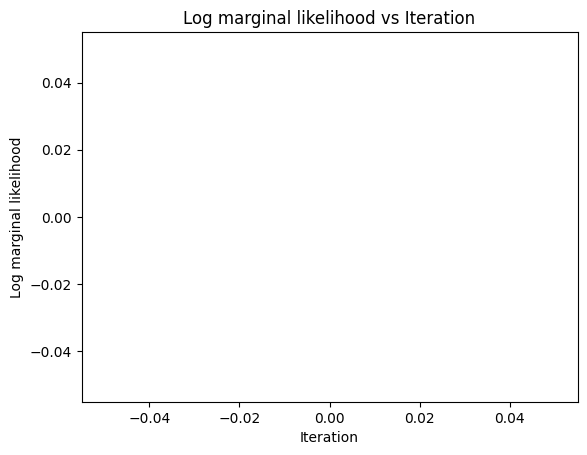

In [162]:
# plot log marginals
plt.plot(log_marginals,label='Estimated log marginal')
# plt.plot(true_logmarginal, label='True log marginal')
plt.xlabel('Iteration')
plt.ylabel('Log marginal likelihood')
plt.title('Log marginal likelihood vs Iteration')

In [163]:
# calculate log marginal over a grid of lengthscales and variances
lengthscales = torch.linspace(0.0001, 0.25, 50)
variances = torch.linspace(0.1, 5, 50)
log_marginals_grid = torch.zeros((len(lengthscales), len(variances)))
for i, lengthscale in enumerate(lengthscales):
    for j, variance in enumerate(variances):
        kernel = SquaredExponential(dimension=1, lengthscale=lengthscale.item(), variance=variance.item())
        log_marginals_grid[i, j] = kernel.log_marginal(x, y, sigmasq)


/var/folders/w7/6nm4rxb53x55tjtr3b5k86b80000gn/T/ipykernel_42429/700715247.py:56: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(true_length_scale, true_variance, color='black', edgecolors='w', s=50, marker='x', label='True', zorder=12)
/var/folders/w7/6nm4rxb53x55tjtr3b5k86b80000gn/T/ipykernel_42429/700715247.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[.01, 0, 0.75, 1])


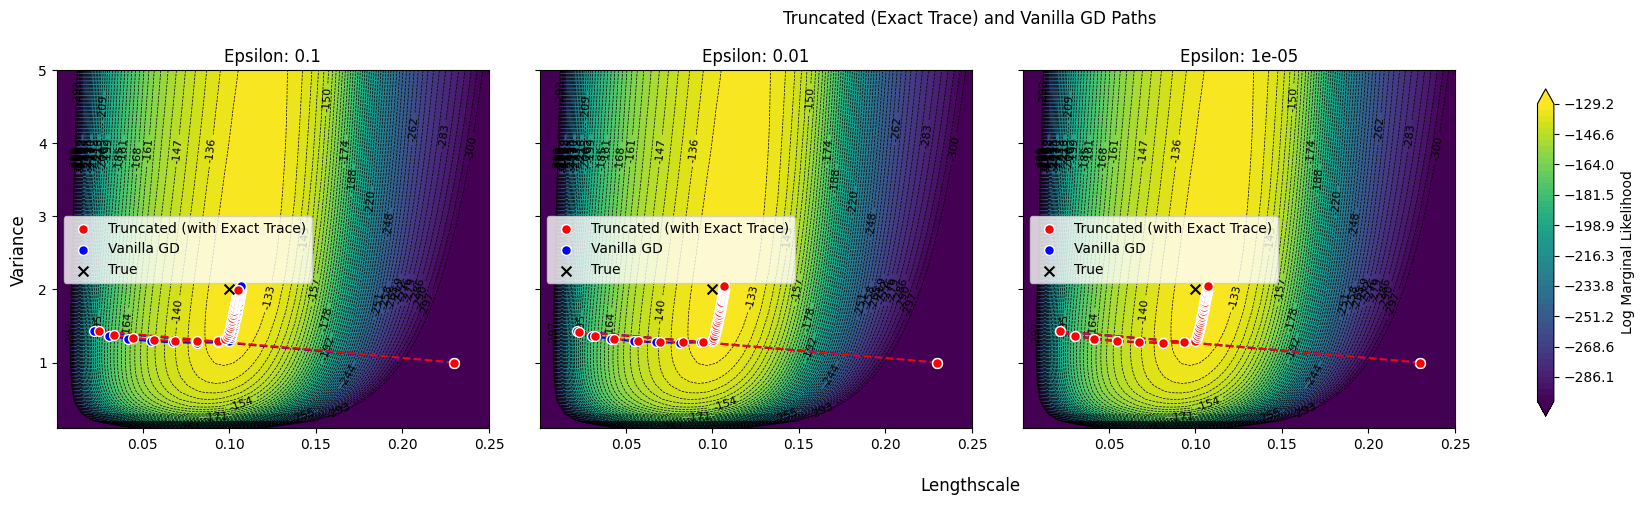

In [164]:
import numpy as np
import matplotlib.pyplot as plt

# For numerical stability, clip extremely low log marginal values.
log_marginal_clipped = np.clip(log_marginals_grid, -100, log_marginals_grid.max())
log_marginal_clipped = log_marginals_grid

# Set up detailed filled contour levels and slightly fewer levels for the line overlay.
fill_levels = np.linspace(-300, log_marginals_grid.max(), 50)
line_levels = np.linspace(-300, log_marginals_grid.max(), 50)

# Number of epsilon runs you have in results_exacttrace.
n_plots = len(results_exacttrace)

# Choose a layout: here we use 2 rows and as many columns as needed.
n_rows = 1
n_cols = int(np.ceil(n_plots / n_rows))

# Convert vanilla SGD tracking lists to arrays.
tracked_lengthscales_vanilla_arr = np.array(tracked_lengthscales_vanilla)
tracked_variances_vanilla_arr  = np.array(tracked_variances_vanilla)

# Create a grid of subplots for visualization.
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten to a 1D list for easy iteration

# Iterate over each subplot (each corresponding to a different epsilon value)
for i, ax in enumerate(axes):
    if i < n_plots:
        # Retrieve the current epsilon run's results.
        res = results_exacttrace[i]
        tracked_lengthscales_path = np.array(res.get('tracked_lengthscales', []))
        tracked_variances_path   = np.array(res.get('tracked_variances', []))
        
        # Plot the filled contours of log marginal likelihood.
        cf = ax.contourf(lengthscales, variances, log_marginal_clipped.T,
                         levels=fill_levels, cmap='viridis', extend='both')
        # Overlay contour lines.
        cs = ax.contour(lengthscales, variances, log_marginal_clipped.T,
                        levels=line_levels, colors='k', linewidths=0.5)
        ax.clabel(cs, inline=True, fontsize=8, fmt='%1.0f')
        

        
        # Plot the results_exacttrace SGD path for the current epsilon:
        ax.scatter(tracked_lengthscales_path, tracked_variances_path,
                   color='red', edgecolors='w', s=50, label='Truncated (with Exact Trace)', zorder=11)
        ax.plot(tracked_lengthscales_path, tracked_variances_path,
                color='red', linestyle='--', zorder=10)
        # Plot the vanilla SGD path:
        ax.scatter(tracked_lengthscales_vanilla_arr, tracked_variances_vanilla_arr,
                   color='blue', edgecolors='w', s=50, label='Vanilla GD', zorder=10)
        ax.plot(tracked_lengthscales_vanilla_arr, tracked_variances_vanilla_arr,
                color='blue', linestyle='--', zorder=9)
        # plot an x at the true lengthscale and variance
        ax.scatter(true_length_scale, true_variance, color='black', edgecolors='w', s=50, marker='x', label='True', zorder=12)
        
        # Set a title that indicates the epsilon and trace_samples for this run.
        ax.set_title(f"Epsilon: {res['epsilon']}", fontsize=12)
        ax.legend(fontsize=10)
    else:
        # If there is no data to plot in this subplot, hide the axis.
        ax.axis('off')

# Add a colorbar to the entire figure using the last filled contour plot reference (cf).
cbar = fig.colorbar(cf, ax=axes.tolist(), label='Log Marginal Likelihood',
                    shrink=0.85, orientation='vertical', pad=0.02)
cbar.ax.tick_params(labelsize=10)

# Label the common x and y axes.
fig.supxlabel('Lengthscale', fontsize=12)
fig.supylabel('Variance', fontsize=12)

# Adjust layout to fit all subplots and the colorbar nicely.
plt.suptitle('Truncated (Exact Trace) and Vanilla GD Paths')

plt.tight_layout(rect=[.01, 0, 0.75, 1])
plt.show()


# make a figure first that shows that as epsilon goes to 0, then SGD is the same as the vanilla

# next a figure that compares stoch trace estimate w vanilla SGD

In [165]:
log_marginals_grid

tensor([[-1441.7637, -1026.3053,  -833.8170,  ...,  -567.2665,  -569.1577,
          -571.0335],
        [ -876.3351,  -592.1721,  -481.0331,  ...,  -397.1404,  -398.7269,
          -400.2953],
        [ -641.6071,  -427.9171,  -350.9977,  ...,  -314.0216,  -315.2412,
          -316.4456],
        ...,
        [ -739.3453,  -589.5816,  -518.5375,  ...,  -294.1680,  -293.6140,
          -293.0800],
        [ -766.9088,  -613.3474,  -539.5084,  ...,  -299.6024,  -298.9834,
          -298.3867],
        [ -795.2372,  -638.0941,  -561.4463,  ...,  -305.6250,  -304.9305,
          -304.2607]])

/var/folders/w7/6nm4rxb53x55tjtr3b5k86b80000gn/T/ipykernel_42429/1323779054.py:57: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(true_length_scale, true_variance, color='black', edgecolors='w', s=50, marker='x', label='True', zorder=12)
/var/folders/w7/6nm4rxb53x55tjtr3b5k86b80000gn/T/ipykernel_42429/1323779054.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[.01, 0, 0.75, 1])  # Adjust layout to make space for the colorbar


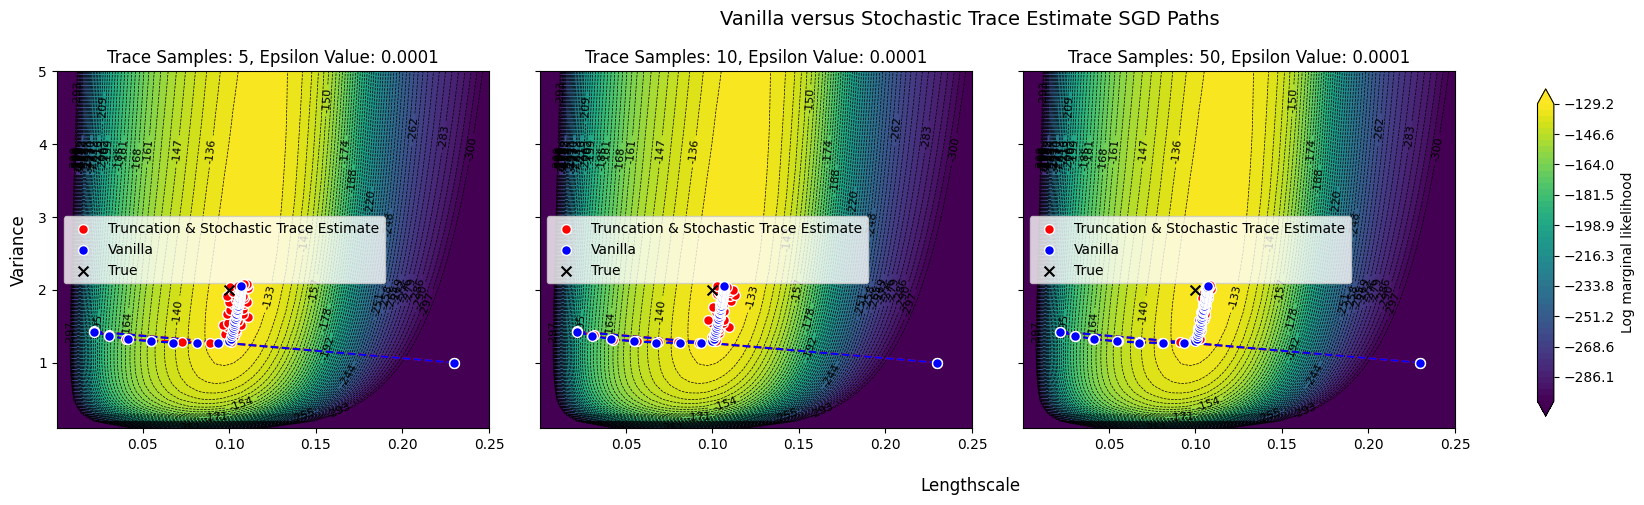

In [166]:

import numpy as np
import matplotlib.pyplot as plt

# Clip values below -100 to prevent extreme low outliers
log_marginal_clipped = np.clip(log_marginals_grid, -100, log_marginals_grid.max())
log_marginal_clipped = log_marginals_grid

# Set up filled contour levels (detailed)
# set fill and line levels based on the data

fill_levels = np.linspace(-300, log_marginals_grid.max(), 50)
# Use fewer contour levels for the line overlay
line_levels = np.linspace(-300, log_marginals_grid.max(), 50)

# Determine subplot grid dimensions for 2 rows
n_plots = len(results)
n_rows = 1
n_cols = int(np.ceil(n_plots / n_rows))
tracked_lengthscales_vanilla_arr = np.array(tracked_lengthscales_vanilla)
tracked_variances_vanilla_arr = np.array(tracked_variances_vanilla)
# Create a grid of subplots with 2 rows and the required number of columns
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration
# Plot each result in its respective subplot
for i, ax in enumerate(axes):
    # if i < n_plots:  # Only plot if there's data for this subplot
    #     tracked_lengthscales_truncated_arr = tracked_lengthscales_truncated
    #     tracked_variances_truncated_arr = tracked_variances_truncated
    if i < n_plots:  # Only plot if there's data for this subplot
        # Plot filled contours
        cf = ax.contourf(lengthscales, variances, log_marginal_clipped.T,
                         levels=fill_levels, cmap='viridis', extend='both')
        # Overlay a reduced number of contour lines for clarity
        cs = ax.contour(lengthscales, variances, log_marginal_clipped.T,
                        levels=line_levels, colors='k', linewidths=0.5)
        ax.clabel(cs, inline=True, fontsize=8, fmt='%1.0f')

        # Overlay tracked hyperparameter points for the current result
        # Ensure tracked_lengthscales and tracked_variances are properly populated
        tracked_lengthscales_arr = np.array(results[i].get('tracked_lengthscales', []))
        tracked_variances_arr = np.array(results[i].get('tracked_variances', []))
        ax.scatter(tracked_lengthscales_arr, tracked_variances_arr,
                   color='red', edgecolors='w', s=50, label='Truncation & Stochastic Trace Estimate', zorder=10)
        ax.plot(tracked_lengthscales_arr, tracked_variances_arr,
                color='red', linestyle='--', zorder=9)
        # overlay vanilla tracked points

        ax.scatter(tracked_lengthscales_vanilla_arr, tracked_variances_vanilla_arr,
                   color='blue', edgecolors='w', s=50, label='Vanilla', zorder=10)
        ax.plot(tracked_lengthscales_vanilla_arr, tracked_variances_vanilla_arr,
                color='blue', linestyle='--', zorder=9)
        #overlay truncated tracked points

        # ax.scatter(tracked_lengthscales_truncated_arr, tracked_variances_truncated_arr,
        #            color='green', edgecolors='w', s=50, label='Tracked points (Truncated)', zorder=10)
        # Set title for each subplot
        ax.scatter(true_length_scale, true_variance, color='black', edgecolors='w', s=50, marker='x', label='True', zorder=12)

        ax.set_title(f"Trace Samples: {results[i]['trace_samples']}, Epsilon Value: {results[i]['epsilon']}", fontsize=12)
        
        # add legend
        ax.legend(fontsize=10)

    else:
        # If no data is available for this subplot, turn the axis off.
        ax.axis('off')

# Add a colorbar to the figure, placed outside the subplots
cbar = fig.colorbar(cf, ax=axes.tolist(), label='Log marginal likelihood', shrink=0.85, orientation='vertical', pad=0.02)
cbar.ax.tick_params(labelsize=10)
# Label the shared axes
fig.supxlabel('Lengthscale', fontsize=12)
fig.supylabel('Variance', fontsize=12)
plt.suptitle('Vanilla versus Stochastic Trace Estimate SGD Paths', fontsize=14)
plt.tight_layout(rect=[.01, 0, 0.75, 1])  # Adjust layout to make space for the colorbar
plt.show()


In [167]:
# results[-1]['log_marginals'][-1]

In [168]:
results[-1]['tracked_noises'][-1]

tensor(0.0974, dtype=torch.float64)

In [169]:
log_marginals_grid.max()

tensor(-129.1784)

In [170]:
results[-3]['tracked_lengthscales']

[0.23000000417232513,
 0.02163680944189989,
 0.030251641722788398,
 0.040176460299041886,
 0.054635002674756655,
 0.07283792301989292,
 0.08848024659754901,
 0.10086939838015296,
 0.1000608791816104,
 0.10256304182439974,
 0.09769370364931981,
 0.10357552928471284,
 0.10406013441796344,
 0.09833194692499908,
 0.0963025652500979,
 0.10675771831113987,
 0.09900445937145258,
 0.1050783260584364,
 0.10354734659811639,
 0.110909621711382,
 0.10146911972932532,
 0.09839364375768232,
 0.10804552125898365,
 0.10042922298355253,
 0.10800188798104665,
 0.1023842026049821,
 0.10223947972670909,
 0.10818468732257877,
 0.09995558362683514,
 0.10714324670963467,
 0.11017663126791352,
 0.10402918989556777,
 0.0984862511043217,
 0.10761044469063043,
 0.10404102657133782,
 0.10863131252627493,
 0.10547317864536067,
 0.10808872140401747,
 0.10485161046736569,
 0.10533909361173674,
 0.10208288186880728,
 0.10509892836661845,
 0.10799572321431126,
 0.10010968932906987,
 0.11073699401082718,
 0.10546626388

$$\alpha = (K+\sigma^2 I)^{-1}y$$

$$\frac{\partial (K + \sigma^2 I)}{\partial \theta} = FD'F^* + \frac{\partial (\sigma^2 I)}{\partial \theta}$$
where 
$$D'_{jj} = h\frac{\partial }{\partial \theta} \hat{k}_\theta(\xi_j)

# note missing timing in efgp1d